In [1]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')

from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy

from tqdm.notebook import tqdm

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing

In [2]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')

submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [3]:
train_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371


In [4]:
train_features.shape

(23814, 876)

In [5]:
train_features.cp_type.value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

In [6]:
train_features.cp_dose.value_counts()

D1    12147
D2    11667
Name: cp_dose, dtype: int64

In [7]:
def preprocess(df):
    df = df.copy()
    df.drop(['cp_type'], axis=1, inplace=True)
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})    
    df = pd.get_dummies(df, columns=['cp_time','cp_dose'])
    del df['sig_id']
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

In [8]:
# Fit scaler to joint train and test data
scaler = preprocessing.MinMaxScaler()
scaler.fit(train.append(test))

train_trans = scaler.transform(train)
test_trans = scaler.transform(test)

train = pd.DataFrame(train_trans, columns=train.columns)
test = pd.DataFrame(test_trans, columns=test.columns)

In [9]:
somthing_rate = 1e-15
P_MIN = somthing_rate
P_MAX = 1 - P_MIN

def loss_fn(yt, yp):
    yp = np.clip(yp, P_MIN, P_MAX)
    return log_loss(yt, yp, labels=[0,1])


In [10]:
def create_model(num_columns, actv='relu'):
    model = tf.keras.Sequential([tf.keras.layers.Input(num_columns)])
                
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation=actv)))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation=actv))) 

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid")))
    
    model.compile(optimizer=tfa.optimizers.AdamW(lr = 1e-3, weight_decay = 1e-5, clipvalue = 756), 
                  loss=BinaryCrossentropy(label_smoothing=somthing_rate),
                  )
    return model

In [11]:
# Use All feats as top feats
top_feats = [i for i in range(train.shape[1])]
print("Top feats length:",len(top_feats))

Top feats length: 877


In [12]:
mod = create_model(len(top_feats))
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 877)               3508      
_________________________________________________________________
dropout (Dropout)            (None, 877)               0         
_________________________________________________________________
weight_normalization (Weight (None, 1024)              1799169   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 1024)              2100225   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4

In [13]:
def metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(loss_fn(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float)))
    return np.mean(metrics)

In [14]:
res_relu = train_targets.copy()
res_relu.loc[:, train_targets.columns] = 0

ss_relu = submission.copy()
ss_relu.loc[:, train_targets.columns] = 0

#ss.loc[:, train_targets.columns] = 0
ss_dict = {}

historys = dict()

tf.random.set_seed(42)


for seed in range(10):
    for n, (tr, te) in enumerate(MultilabelStratifiedKFold(n_splits=6, random_state=seed, shuffle=True).split(train_targets, train_targets)):
        print(f"======{train_targets.values[tr].shape}========{train_targets.values[te].shape}=====")
        
        print(f'Seed: {seed} => Fold: {n} ==> (RELU MODEL)')
        model = create_model(len(top_feats), actv='relu')

        
        checkpoint_path = f'repeat:{seed}_Fold:{n}.hdf5'
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6, patience=4, verbose=1, mode='auto')
        cb_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose = 1, save_best_only = True,
                                     save_weights_only = True, mode = 'auto')
        early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience= 10, verbose = 1)
        
        history = model.fit(train.values[tr][:, top_feats],
                  train_targets.values[tr],
                  validation_data=(train.values[te][:, top_feats], train_targets.values[te]),
                  epochs=60, batch_size=128,
                  callbacks=[reduce_lr_loss, cb_checkpt, early], verbose=2
                 )
        
        historys[f'history_{seed+1}'] = history
        print("Model History Saved.")
        
        model.load_weights(checkpoint_path)
        
        test_predict = model.predict(test.values[:, top_feats])
        val_predict = model.predict(train.values[te][:, top_feats])

        ss_relu.loc[:, train_targets.columns] += test_predict
        res_relu.loc[te, train_targets.columns] += val_predict
            
        print(f'OOF Metric For SEED {seed} => FOLD {n} : {metric(train_targets.loc[te, train_targets.columns], pd.DataFrame(val_predict, columns=train_targets.columns))}')
        print('+-' * 10)
        
ss_relu.loc[:, train_targets.columns] /= 25
res_relu.loc[:, train_targets.columns] /= 25


======(19845, 206)========(3969, 206)=====
Seed: 0 => Fold: 0 ==> (RELU MODEL)
Epoch 1/60

Epoch 00001: val_loss improved from inf to 0.03666, saving model to repeat:0_Fold:0.hdf5
156/156 - 1s - loss: 0.2693 - val_loss: 0.0367
Epoch 2/60

Epoch 00002: val_loss improved from 0.03666 to 0.02197, saving model to repeat:0_Fold:0.hdf5
156/156 - 1s - loss: 0.0261 - val_loss: 0.0220
Epoch 3/60

Epoch 00003: val_loss improved from 0.02197 to 0.01917, saving model to repeat:0_Fold:0.hdf5
156/156 - 1s - loss: 0.0196 - val_loss: 0.0192
Epoch 4/60

Epoch 00004: val_loss improved from 0.01917 to 0.01726, saving model to repeat:0_Fold:0.hdf5
156/156 - 1s - loss: 0.0177 - val_loss: 0.0173
Epoch 5/60

Epoch 00005: val_loss improved from 0.01726 to 0.01682, saving model to repeat:0_Fold:0.hdf5
156/156 - 1s - loss: 0.0167 - val_loss: 0.0168
Epoch 6/60

Epoch 00006: val_loss improved from 0.01682 to 0.01671, saving model to repeat:0_Fold:0.hdf5
156/156 - 1s - loss: 0.0181 - val_loss: 0.0167
Epoch 7/60

E

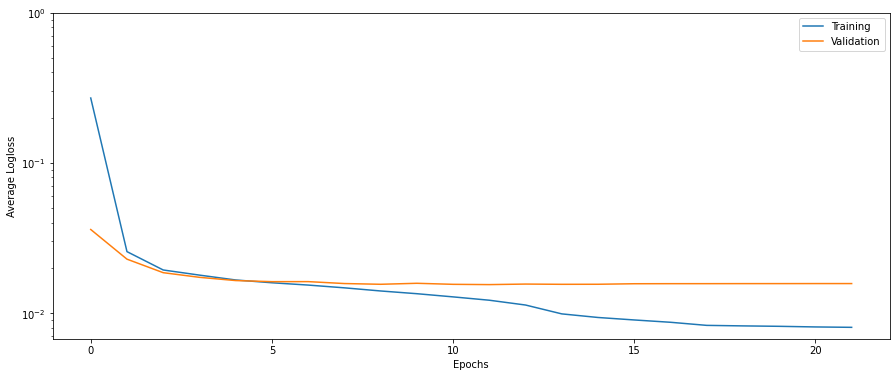

In [15]:
# Show Model loss in plots

for k,v in historys.items():
    loss = []
    val_loss = []
    
    loss.append(v.history['loss'][:40])
    val_loss.append(v.history['val_loss'][:40])
    
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 6))
plt.plot(np.mean(loss, axis=0))
plt.plot(np.mean(val_loss, axis=0))
plt.yscale('log')
plt.yticks(ticks=[1,1e-1,1e-2])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [16]:
print(f'OOF Metric (relu): {metric(train_targets, res_relu)}')
#print(f'OOF Metric (elu): {metric(train_targets, res_elu)}')

OOF Metric (relu): 0.01639772398634687


In [17]:
ss_relu.to_csv('submission.csv', index=False)